# Rekall Tutorial

[Rekall](https://docs.google.com/document/d/1JJr6Io25OoN5826nSqIaLPQ5aNJ2L2nppjD7l9l4vTI) is a library for combining and transforming spatiotemporal volumes (aka intervals). This document is a simple tutorial that demonstrates how to use rekall in Esper.

## Writing a Rekall Query

One should refer to the paper "Large-Scale Video Analysis and Synthesis using Compositions of
Spatiotemporal Labels" for how to think about intervals and the basic operations available on them.
Usually one picks a few videos on which to develop the query, so as an example we write a function from video_ids to a DomainIntervalCollection with video_id as domain key.

In [ ]:
def faces_rekall(vids):
    from query.models import Face
    from django.db.models import F, ExpressionWrapper, IntegerField
    from rekall.domain_interval_collection import DomainIntervalCollection
    
    # We sample one frame every 3 seconds
    SAMPLE_RATE=3
    
    # We will use frame number as the temporal dimension
    queryset = Face.objects.filter(frame__video_id__in=vids).annotate(
        video_id = F('frame__video_id'),
        min_frame = F('frame__number'),
        max_frame = ExpressionWrapper(
            F('frame__number') + SAMPLE_RATE*F('frame__video__fps'),
            output_field=IntegerField())
    )
    
    # Default schema uses min_frame, max_frame for temporal dimension and video_id for domain key
    schema = DomainIntervalCollection.django_bbox_default_schema()
    
    # For each video, faces contains a IntervalSet3D of face bounding volumes.
    faces = DomainIntervalCollection.from_django_qs(queryset, schema, progress=True)
    
    # An IntervalSet of frames with IntervalSet of Faces as payload
    frames_with_faces = faces.group_by_time()
    return frames_with_faces

## Visualizing Rekall Query Results

We can use [VGrid](https://docs.google.com/document/d/1ciW6J9H7KKxKQOxssjta2lgtxK7bUzvJH8boxUSdtvQ) to visualize the resulting intervals of the rekall query.

VGrid expects a DomainIntervalCollection keyed by video_id and that the temporal dimensions are frame numbers in the video. Currently we are still building out the glue between 3D Rekall and VGrid, so for now we can revert back to 1D rekall to visualize the intervals.

In [ ]:
def convert_to_1d(collection_3d):
    from rekall.interval_list import Interval
    from rekall.video_interval_collection import VideoIntervalCollection
    return VideoIntervalCollection({vid: [Interval(
        i.t[0], i.t[1], None) for i in collection_3d[vid].get_intervals()] for vid in collection_3d})

def display_result(collection_1d):
    from esper.widget import esper_widget
    from esper.rekall import intrvllists_to_result
    results = intrvllists_to_result(collection_1d.get_allintervals())
    return esper_widget(results,
            crop_bboxes=False, show_middle_frame=False, disable_captions=True,
            results_per_page=25, jupyter_keybindings=True)

Let's run the query on the first 5 videos and visualize the results.

In [ ]:
display_result(convert_to_1d(faces_rekall(range(6))))

## Executing Rekall in Chunks

With over 200K videos in TV News, it is not practical to get all the faces out in one go. In fact, trying to run the above query on more than 40 videos will get the program stuck. Rekall comes with a Runtime library that help with chunking the work into e.g. 15 videos at a time. Specifically, the inline runtime does exactly that.

In [ ]:
def run_in_chunks(vids, chunksize=15):
    from rekall.runtime import Runtime
    return Runtime.inline().run(faces_rekall, vids, chunksize=chunksize)[0]

Let's run the query on 50 videos, 15 at a time.

In [ ]:
answer = run_in_chunks(list(range(51)), chunksize=15)

## Executing Rekall Queries on Many Videos in Parallel

If we have now finalized the rekall query on the development set of videos and would like to run it on all data we have, we can efficiently run the query on a multicore machine using the same Runtime library.

First, we need to spin up some workers. Go to the Jupyter Notebook home page and click on IPython Clusters tab, find the "local" profile, put in the number of engines and click "start". 

Alternatively, we can go into the docker container and run `ipcluster --profile=local` to the same effect. An optional `-n 16` flag will tell it to spin up 16 workers. If omitted it will use the number of cpu cores by default.

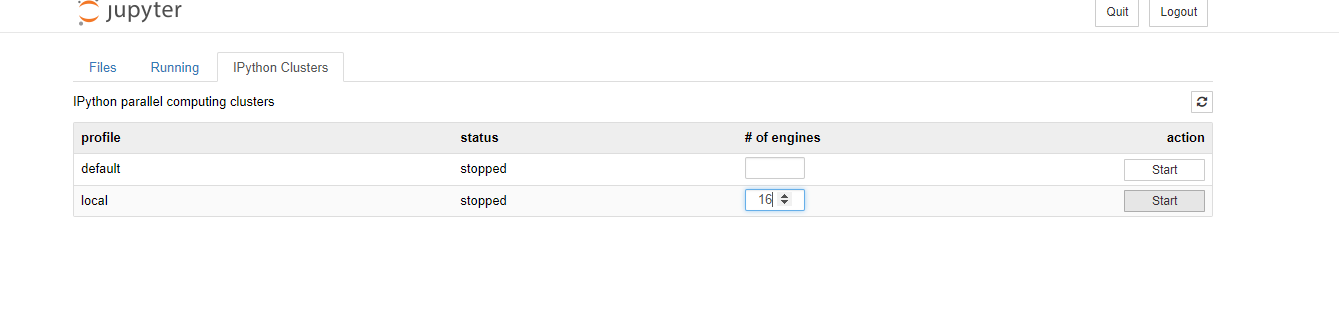

In [ ]:
def run_in_parallel(vids):
    import ipyparallel as ipp
    from esper.rekall_parallel import get_runtime_for_ipython_cluster
    from rekall.runtime import disjoint_domain_combiner
    c = ipp.Client(profile='local')
    rt = get_runtime_for_ipython_cluster(c)
    return rt.run(faces_rekall, vids, chunksize=15, progress=True, combiner=disjoint_domain_combiner)[0]

Now we can run the query on first 1000 videos. Since each chunk has disjoint domain (video_ids), we can use the faster disjoint_domain_combiner instead of the slower default union combiner.

In [ ]:
answer = run_in_parallel(list(range(1001)))

## Streaming Results

One can also get a stream of DomainIntervalCollection results on the chunks of work as they finish from the Runtime library. It lazily sends more work to workers as results are consumed

In [ ]:
def get_generator(vids):
    import ipyparallel as ipp
    from esper.rekall_parallel import get_runtime_for_ipython_cluster
    from rekall.runtime import disjoint_domain_combiner
    c = ipp.Client(profile='local')
    rt = get_runtime_for_ipython_cluster(c)
    return rt.get_result_iterator(faces_rekall, vids, randomize=False, chunksize=15)

In [ ]:
gen = get_generator(list(range(200000)))
next(gen)

# Tips

1. The ipython cluster workers are long-running processes that have internal states. If there is a strange bug only when running in ipython cluster, consider restarting the cluster to clear the state.
2. The Tutorial shows how to parallelize a query over video ids. It does not have to be that way. There is an example query of finding Donald Trump on all channels at the same time in the rekalling_entire_tvnews notebook that parallelize over dates.